# **Email Spam Classification**

**Real World/Business Problem**

In recent times, unwanted industrial bulk emails known as spam has become an enormous drawback on the net. The person causing the spam messages is noted because the sender. Such an individual gathers email addresses from completely different websites, chat rooms, and viruses. Spam prevents the user from creating full and sensible use of your time, storage capability and network information measure.  

**Problem Statement**

Spam mails are the major issue on the internet. It is easy to send an email which contains spam message by the spammers. Spam fills our inbox with several irrelevant emails. Spammers can steal our sensitive information from our device like files, contact.**We need to identify whether the given mail is spam or not.**

**Source/Usefull links**



1.   https://towardsdatascience.com/email-spam-detection-1-2-b0e06a5c0472
2.   https://turkjphysiotherrehabil.org/pub/pdf/321/32-1-242.pdf
3.   https://sdsawtelle.github.io/blog/output/spam-classification-part2-vectorization-and-svm-pipeline.html

4.  https://www.kaggle.com/ganiyuolalekan/building-an-email-spam-classifier
5.  https://www.kaggle.com/ragnisah/text-data-cleaning-tweets-analysis
6.  https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

7. https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2



**Machine Learning Problem**

**Data Overview**

1.	The dataset (spam_assassin.csv) provided here is a combination of the spam, spam 2, easy ham, and easy ham 2.
2.	The dataset contains 2 columns “Email Text” and “Target”. 
3.	The “Email Text” column contains email header, subject and content. The “Target” variable 0 represent “not spam” and 1 represent “spam”. The ratio of non-spam to spam class is 3900:1896 this is an imbalanced dataset. 


Dataset: https://www.kaggle.com/ganiyuolalekan/spam-assassin-email-classification-dataset

**Machine Learing Objectives and Constraints**


Objective: Predict the probability of each data-point being spam or not spam.

Constraints: Change Threshold to get the best F beta score.

**Train and Test Dataset**

Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

**Evaluation Metric**

For the case of Email spam classification the dataset is imbalanced and we need to classify all the positive points correctly.We have to give more weightage to Precision So we can use f beta score where beta = 0.5.We have to find the threshold value which this f-0.5 score is high.
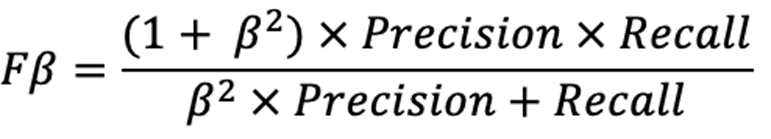 

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import gensim
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix,hstack
from tqdm import tqdm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


loading the dataset.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/spam_assassin.csv')

In [ ]:
df.head()

,text,target
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0


# **Data Cleaning,Preprocessing and Featurization**

In [ ]:
import re 
class TextPreprocessor():

  def extract_email_ids(self,doc):
    '''This functions extract the email ids and domain names in the email adderss and returns a list of preprocessed email ids'''
    list_of_preproessed_emails = []
    list_of_emails = re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',doc)
    doc = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'," ",doc)
    for txt in list_of_emails:
      email = re.split("[.]",re.split("@", txt)[1])
      y=email.copy()
      for i in email:
        if i=="com" or len(i)<=2:
          y.remove(i)
      email = ' '.join([str(i) for i in y])
      email = email.lower()
      list_of_preproessed_emails.append(email)
    list_of_preproessed_emails = " ".join(list_of_preproessed_emails)
    return list_of_preproessed_emails

  def text_lowercase(self,doc):
    ''' This function converts the text to lower case'''
    return doc.lower()

  def remove_digits(self, doc):
    '''This function removes all the numbers'''
    return re.sub('\d', '', doc)

  def remove_underscores(self, doc):
    '''This function removes all the underscores'''
    return re.sub(r'_', '', doc)

  def remove_excess_whitespace(self, doc):
    '''This function removes excess white spaces'''
    return re.sub('\s+', ' ', doc)

  def remove_special_characters(self, doc):
    '''This function removes all the special characters'''
    return re.sub('\W', ' ', doc)

  def remove_within_brackets(self, doc):
    '''This function removes all the content within brackets'''
    text = re.sub(r'\([^()]*\)', '', doc)
    text = re.sub(r'<[^()]*>', '', text)
    return text

  def expand_words(self, phrase):
    '''This function expands the short form words '''
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

  def remove_short_and_long_words(self, doc):
    '''This function removes all the short(<2 letters) and long(>15 letters) words '''
    words = doc.split()
    word_list = []
    for word in words:
      if len(word) > 2 and len(word) < 15 :
        word_list.append(word)
    return ' '.join(word_list)

  

  def text_lematizer(self,doc):
    '''This function lematize the words to its root words'''
    nlp = spacy.load('en', disable=['parser', 'ner'])
    doc = nlp(doc)
    return " ".join([token.lemma_ for token in doc])

  def clean_document(self,doc):
    '''This function cleans the documents'''
    doc = self.text_lowercase(doc)
    ids = self.extract_email_ids(doc)
    doc = self.remove_within_brackets(doc)
    doc = self.expand_words(doc)
    doc = self.remove_underscores(doc)
    doc = self.remove_special_characters(doc)
    doc = self.remove_digits(doc)
    doc = self.remove_excess_whitespace(doc)
    doc = self.remove_short_and_long_words(doc)
    doc = self.text_lematizer(doc)
    doc = ids+doc
    return doc

In [ ]:
from pandas.core.common import random_state
from importlib import import_module
class TextFeaturization():

  def load_glove(self):
    '''This function loads the glove word vectors to memory'''
    embeddings_index = dict()
    with open('/content/drive/MyDrive/glove.6B.300d.txt', 'rb') as f:
        for line in f:
          values = line.split()
          word =  re.sub(r"b", "", str(values[0]))
          word = word.replace("'", "")
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs
    f.close()
    glove_words = set(embeddings_index.keys())
    return glove_words,embeddings_index

  def remove_stopwords(self,docs,stopword_list):
    '''This function removes the stop words'''
    clean_docs = []
    for doc in docs:
      word_list = word_tokenize(doc)
      cleaned_txt = [w for w in word_list if not w in email_stopwords]
      cleaned_string = " ".join(cleaned_txt)
      clean_docs.append(cleaned_string)
    
    return clean_docs
    
  def word_count(self,docs):#need to change to corpus
    '''This function retuns an array of word count in each document'''
    doc_len = []
    for doc in docs:
      doc_len.append(len(doc.split()))
    return np.array(doc_len)

  def average_word_length(self,docs):
    '''This function returns an array of average word length in each document'''
    average_word_length = []
    for doc in docs:
      total_length = 0
      for i in doc.split():
        total_length += len(i)
      average_word_length.append(total_length/len(doc.split()))
    return np.array(average_word_length)
    
  def bag_of_words(self,train_data):
    '''This function creates bag of word representation for train data'''
    vectorizer_bow = CountVectorizer()
    vectorizer_bow.fit(train_data)
    text_bow_train = vectorizer_bow.transform(train_data)
    return vectorizer_bow,text_bow_train

  def tfidf_train(self,train_data):
    '''This function creates TFIDF representation of train data'''
    vectorizer_tfidf = TfidfVectorizer(min_df=10)
    vectorizer_tfidf.fit(train_data)
    text_tfidf_train = vectorizer_tfidf.transform(train_data)
    return vectorizer_tfidf,text_tfidf_train

  def tfidf_test(self,tfidf_model,test_data):
    '''This function creates TFIDF representation of test data'''
    return tfidf_model.transform(test_data)

  def avg_word2vec(self,docs):
    glove_words,embeddings_index = self.load_glove()
    avg_wv = []; # the avg-w2v for each sentence/review is stored in this list
    for doc in tqdm(docs): # for each review/sentence
        sent_vec = np.zeros(300) # as word vectors are of zero length 300
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in doc: # for each word in a review/sentence
            if word in glove_words:
                vec = embeddings_index[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        avg_wv.append(sent_vec)
    return avg_wv


#reference: Applied AI Decision tree Assignment Documentation(For TFIDF weighted W2V)
  def tfidf_weighted_word2vec_train(self,train_data):
    '''This function creates TFIDF weighted W2V representation of train data'''
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(train_data)
    # we are converting a dictionary with word as a key, and the idf as a value
    idf_dictionary = dict(zip(tfidf_model.get_feature_names_out(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names_out())
    glove_words,embeddings_index = self.load_glove()
    word_list = []
    # average Word2Vec
    # compute average word2vec for each review.
    tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(train_data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            word_list.append((word in glove_words) and (word in tfidf_words))
            if (word in glove_words) and (word in tfidf_words):
                vec = embeddings_index[word] # getting the vector for each word
                tf_idf = idf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors_train.append(vector)
    return tfidf_w2v_vectors_train,idf_dictionary,tfidf_words

  def tfidf_weighted_word2vec_test(self,test_data,idf_dictionary,tfidf_words):
    '''This function creates TFIDF representation of test data'''
    tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
    glove_words,embeddings_index = self.load_glove()
    for sentence in tqdm(test_data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = embeddings_index[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = idf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
            
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors_test.append(vector)
    return tfidf_w2v_vectors_test

  def topic_modelling(self,train_data):
    '''This function performs lda topic modelling for 2 topics and create trains lda with train data'''
    vectorizer_bow,bow = self.bag_of_words(train_data)
    lda_model = self.sklearn.decomposition.LatentDirichletAllocation(n_components=2, learning_method='online', max_iter=20,random_state=100)
    lda_model.fit(bow)
    train_lda = lda_model.transform(bow)
    return lda_model,vectorizer_bow,train_lda

  def perform_lda(self,train_data,test_data):
    '''This function performs lda on test data'''
    lda_model,vectorizer_bow,train_lda = self.topic_modelling(train_data)
    bow = vectorizer_bow.transform(test_data)
    return lda_model.transform(bow)

  def featurize(self,X_train,X_test,email_stopwords):
    '''This function featurize text data as w2V,word length,avg word length,lda topic modelling for given train and test data'''
    train_doc = self.remove_stopwords(X_train,email_stopwords)
    test_doc = self.remove_stopwords(X_test,email_stopwords)

    word_count_train = self.word_count(train_doc).reshape(-1,1)
    avg_word_len_train = self.average_word_length(train_doc).reshape(-1,1)
    lda_train = np.array(self.topic_modelling(train_doc)[2])
    tfidf_model,tfidf_train_vec = self.tfidf_train(train_doc)
    avg_wv_train = self.avg_word2vec(train_doc)
    tfidf_w2v_vectors_train,idf_dictionary,tfidf_words = self.tfidf_weighted_word2vec_train(train_doc)
    tfidf_w2v_vectors_train = np.array(tfidf_w2v_vectors_train)
    print(tfidf_train_vec.todense().shape)
    email_train = np.hstack((word_count_train,avg_word_len_train,lda_train,tfidf_train_vec.todense(),avg_wv_train,tfidf_w2v_vectors_train))

    word_count_test = self.word_count(test_doc).reshape(-1,1)
    avg_word_len_test = self.average_word_length(test_doc).reshape(-1,1)
    lda_test = self.perform_lda(train_doc,test_doc)
    tfidf_test_vec = self.tfidf_test(tfidf_model,test_doc)
    avg_wv_train = self.avg_word2vec(test_doc)
    tfidf_w2v_vectors_test = np.array(self.tfidf_weighted_word2vec_test(test_doc,idf_dictionary,tfidf_words))
    email_test = np.hstack((word_count_test,avg_word_len_test,lda_test,tfidf_test_vec.todense(),avg_wv_train,tfidf_w2v_vectors_test))

    return email_train,email_test

    

In [ ]:
col = ["Word Count","Average Word length","Topic 1","Topic 2"]

In [ ]:
col.extend(["tfidf_d"+str(i) for i in range(0,3286)])#column name for pandas dataframe
col.extend(["avg_wv_d"+str(i) for i in range(0,300)])
col.extend(["tfidf_w2v_d"+str(i) for i in range(0,300)])

### **Text Preprocessing**

In [ ]:
tp = TextPreprocessor()
processed_text = []
for i in tqdm(df['text']):
  processed_text.append(tp.clean_document(i))

100%|██████████| 5796/5796 [52:00<00:00,  1.86it/s]


In [ ]:
df['clean_text'] = processed_text

In [ ]:
df.to_csv('clean_data.csv')

In [ ]:
df = pd.read_csv('clean_data.csv')

In [ ]:
df.head()

,Unnamed: 0,text,target,clean_text
0,0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0,linux linux localhost netnoteinc lugh tuatha o...
1,1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1,excite excite jmason org wi-poli poli wi-poli ...
2,2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1,xent xent localhost netnoteinc jmason org jmas...
3,3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1,btamail net btamail net jmason org netnoteinc ...
4,4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0,linux linux localhost netnoteinc lugh tuatha o...


### **Text Featurization**

In [ ]:
text_corpus =''
for txt in df['clean_text']:
    txt = txt.lower()
    text_corpus += txt
    

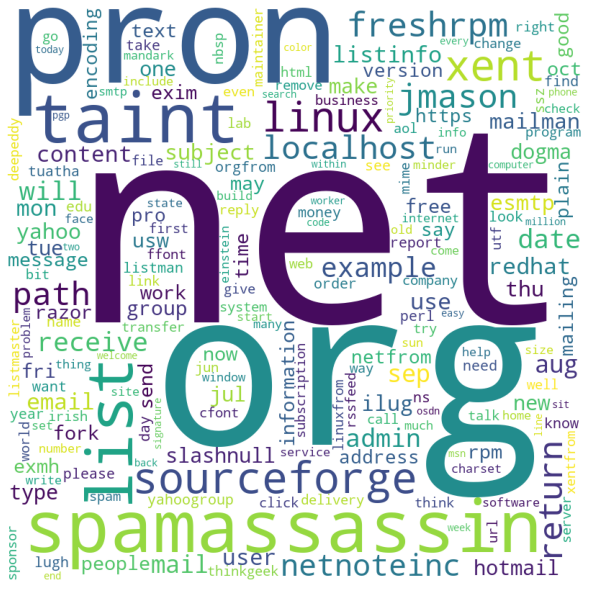

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations = False,
                min_font_size = 10,max_words=200).generate(text_corpus)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
email_stopwords = set(dict(wordcloud.words_).keys()).union(set(stopwords.words('english'))) #get high frequency words from wordcloud and use them as stopwords 

In [ ]:
tf = TextFeaturization()

In [ ]:
X = df['clean_text']
y = df['target']

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
train,test = tf.featurize(X_train,X_test,email_stopwords=email_stopwords)

100%|██████████| 4636/4636 [00:09<00:00, 471.19it/s]


(4636, 3286)


100%|██████████| 1160/1160 [00:03<00:00, 342.94it/s]


In [ ]:
df_train = pd.DataFrame(train,columns=col)#creating dataframe from text features

In [ ]:
y_train = y_train.reset_index()#resetting index of y_train
y_train.drop(['index'],axis=1)

,target
0,1
1,0
2,1
3,0
4,1
...,...
4631,1
4632,1
4633,1
4634,1


In [ ]:
df_train = pd.concat([df_train, y_train], axis = 1)#concatinating df_train and y_train

In [ ]:
df_test = pd.DataFrame(test,columns=col)#creating dataframe from text features

In [ ]:
y_test = y_test.reset_index()#resetting index of y_test
y_test.drop(['index'],axis=1)

,target
0,0
1,0
2,0
3,0
4,0
...,...
1155,0
1156,0
1157,0
1158,0


In [ ]:
df_test = pd.concat([df_test, y_test], axis = 1)#creating dataframe from text features

### **EDA**



1.   **Count plot Class Distribution**



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

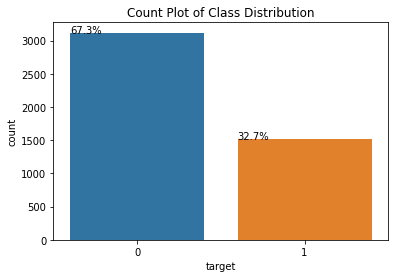

In [ ]:
total = len(y_train)*1
cplt = sns.countplot(x ='target', data = df_train)
for p in cplt.patches:
        cplt.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()))#display percentage of class in x,y position 
plt.title("Count Plot of Class Distribution")
plt.show()

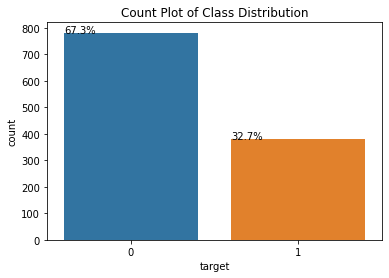

In [ ]:
total = len(y_test)*1
cplt = sns.countplot(x ='target', data = df_test)
for p in cplt.patches:
        cplt.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x(), p.get_height()))
plt.title("Count Plot of Class Distribution")#display percentage of class in x,y position
plt.show()


2.  **Boxplot of word count**



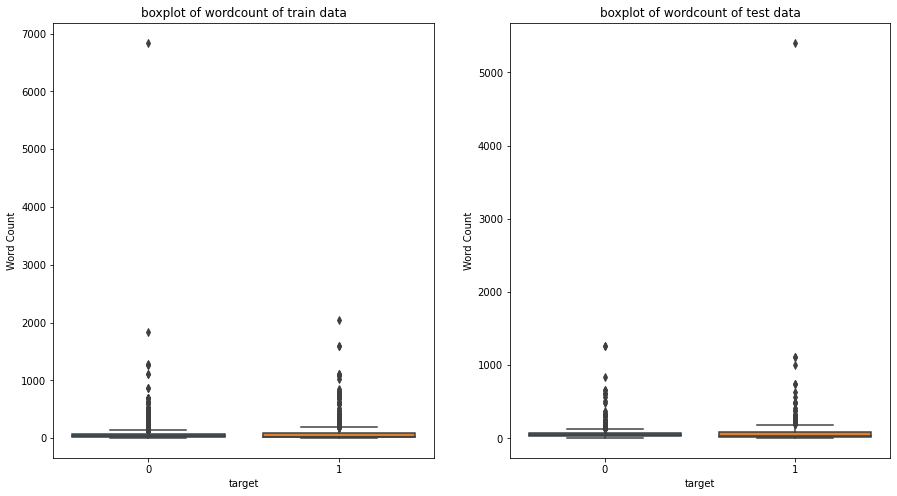

In [ ]:
f, axes = plt.subplots(1, 2,figsize = (15,8))

sns.boxplot(x='target',y='Word Count', data=df_train,ax=axes[0]).set(title='boxplot of wordcount of train data')

sns.boxplot(x='target',y='Word Count', data=df_test,ax=axes[1]).set(title='boxplot of wordcount of test data')

plt.show()

 **Observation:**
From both the train and test data visualizations the distribution is similar and tere is an overlap so this feature be will not be a usefull feature in classification

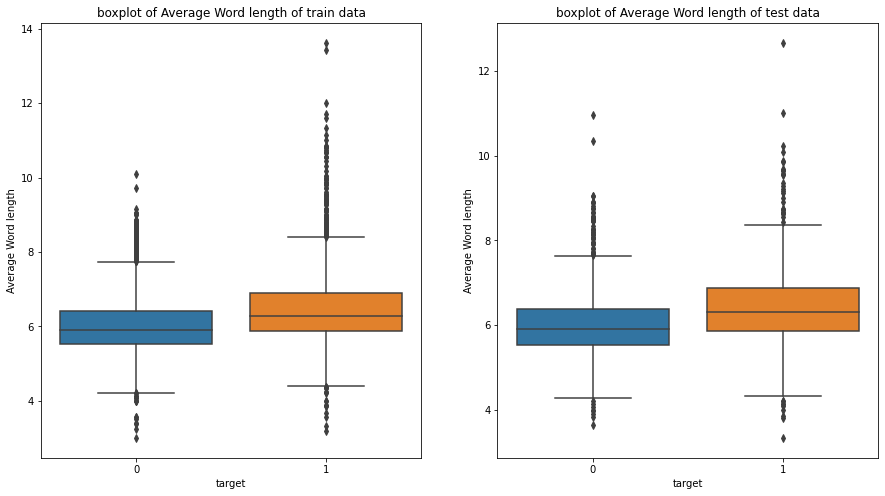

In [ ]:
f, axes = plt.subplots(1, 2,figsize = (15,8))

sns.boxplot(x='target',y="Average Word length", data=df_train,ax=axes[0]).set(title='boxplot of Average Word length of train data')

sns.boxplot(x='target',y="Average Word length", data=df_test,ax=axes[1]).set(title='boxplot of Average Word length of test data')

plt.show()

 **Observations:**
From the plot the there is a overlap but it is a small overlap. the target class "1" ths higher average word length than the target "0".


3. **Boxplot of Topic 1**



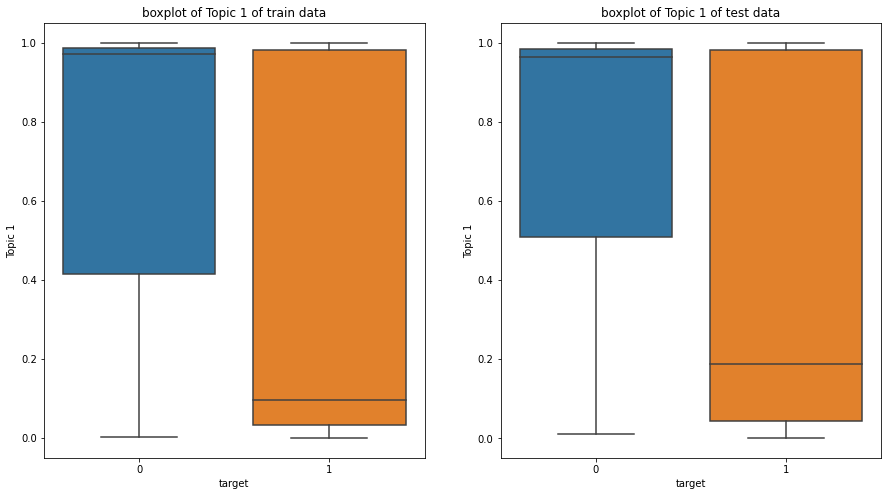

In [ ]:
f, axes = plt.subplots(1, 2,figsize = (15,8))

sns.boxplot(x='target',y='Topic 1', data=df_train,ax=axes[0]).set(title='boxplot of Topic 1 of train data')

sns.boxplot(x='target',y='Topic 1', data=df_test,ax=axes[1]).set(title='boxplot of Topic 1 of test data')

plt.show()

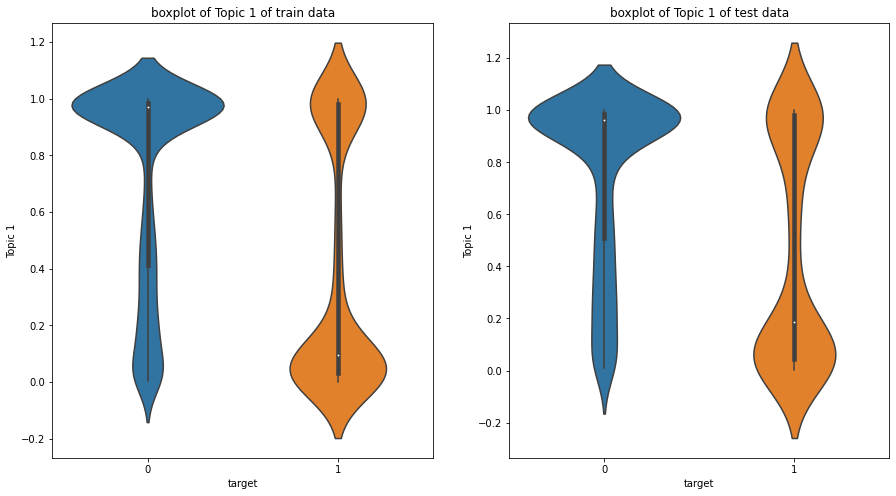

In [ ]:
f, axes = plt.subplots(1, 2,figsize = (15,8))

sns.violinplot(x='target',y='Topic 1', data=df_train,ax=axes[0]).set(title='boxplot of Topic 1 of train data')

sns.violinplot(x='target',y='Topic 1', data=df_test,ax=axes[1]).set(title='boxplot of Topic 1 of test data')

plt.show()

**Observation:**
From the plot for the target class"0" most of the points are concentrates in 0 to 0.2 range(75th percentile) but for target class "1" the points are widespread from 0 to 0.9 range(75th percentile). This is a usefull feature for classification.

**4. Boxplot of Topic 2**

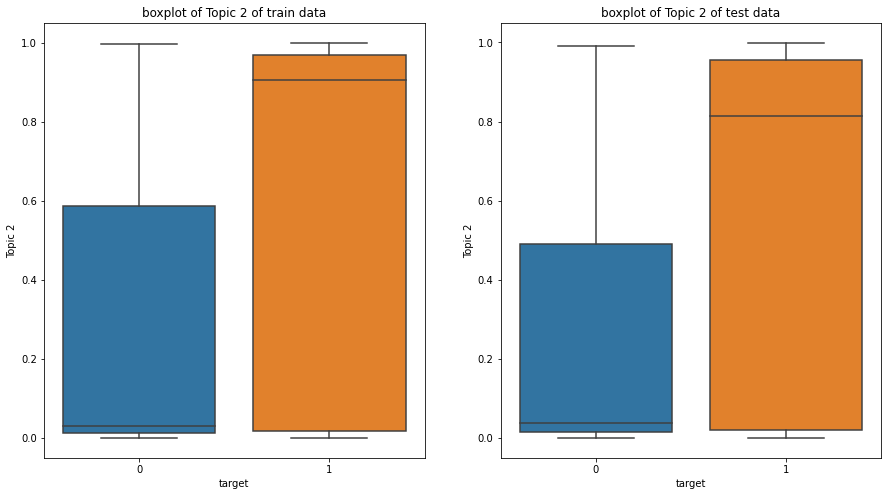

In [ ]:
f, axes = plt.subplots(1, 2,figsize = (15,8))

sns.boxplot(x='target',y='Topic 2', data=df_train,ax=axes[0]).set(title='boxplot of Topic 2 of train data')

sns.boxplot(x='target',y='Topic 2', data=df_test,ax=axes[1]).set(title='boxplot of Topic 2 of test data')

plt.show()

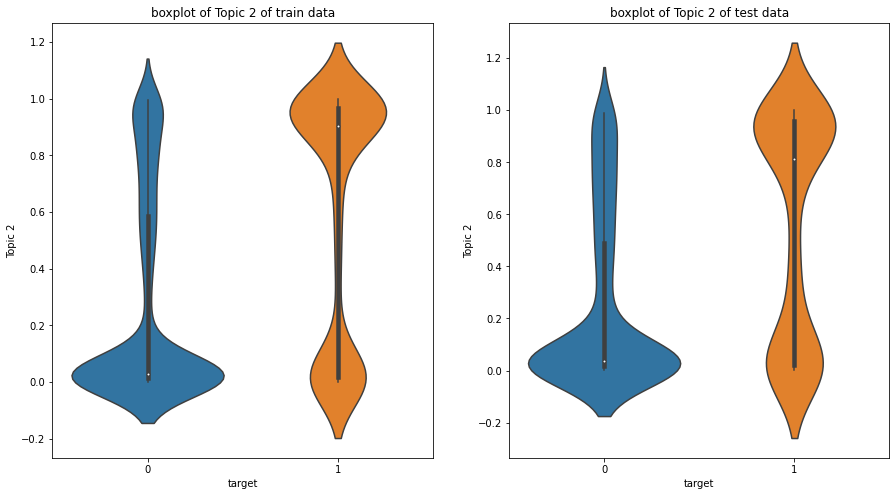

In [ ]:
f, axes = plt.subplots(1, 2,figsize = (15,8))

sns.violinplot(x='target',y='Topic 2', data=df_train,ax=axes[0]).set(title='boxplot of Topic 2 of train data')

sns.violinplot(x='target',y='Topic 2', data=df_test,ax=axes[1]).set(title='boxplot of Topic 2 of test data')

plt.show()

**Observation:**
This plot is similar to "Topic 1" plot but here for target "0" most of the points are concentrated between 0.8 to 1 range(25th to 100th percentile).But the target "1" has more spread 0.2 to 1 range(25th to 100th percentile).This also can be a usefull information.

**Word Cloud visualization**

In [ ]:
#combines all text from all the documents
text_corpus =''
for txt in X_train:
    txt = txt.lower()
    text_corpus += txt 

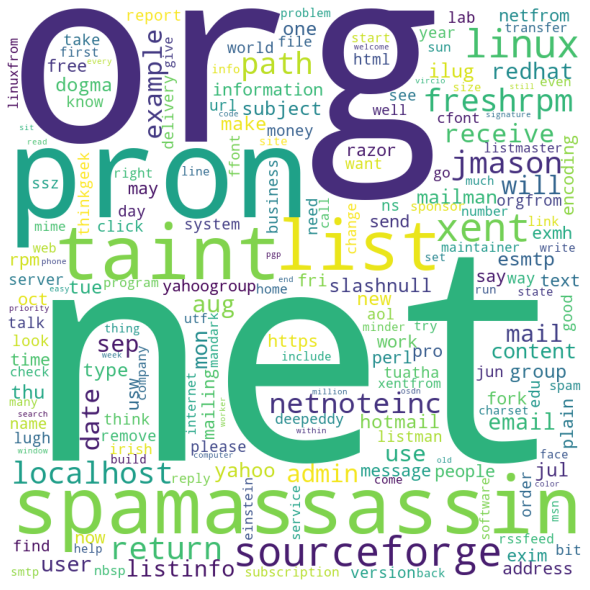

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations = False,
                min_font_size = 10,max_words=200).generate(text_corpus)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
#combines all text from all the documents
text_corpus =''
for txt in X_test:
    txt = txt.lower()
    text_corpus += txt

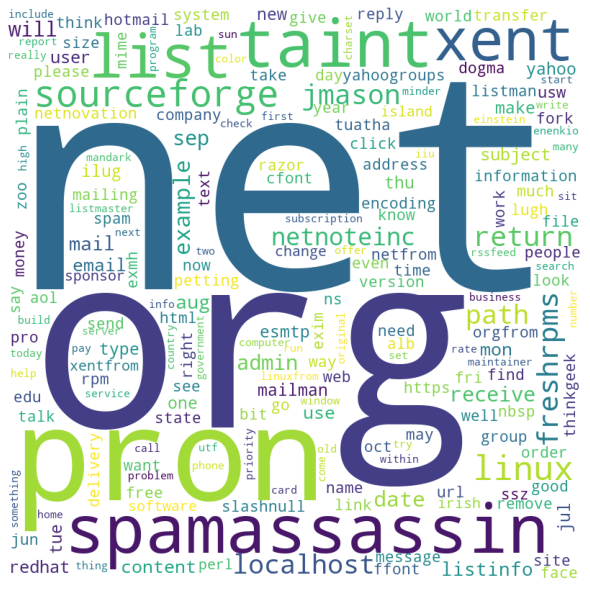

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations = False,
                min_font_size = 10,max_words=200).generate(text_corpus)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

 **5.Join Plot of Topic 1 and Topic 2**

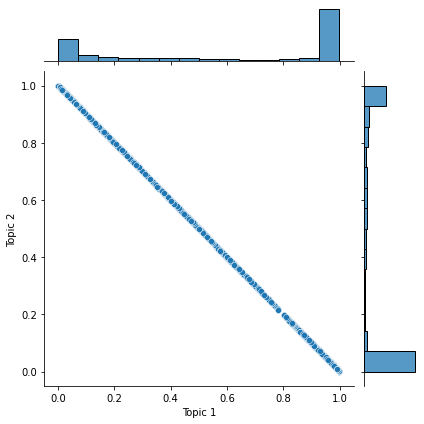

In [ ]:
sns.jointplot(x="Topic 1", y="Topic 2", data=df_train)
plt.show();

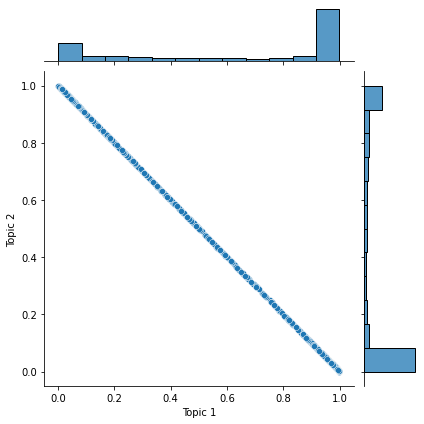

In [ ]:
sns.jointplot(x="Topic 1", y="Topic 2", data=df_test)
plt.show();

**Obervation:**
From the jointplot of Topic 1 and Topic 2 it is clear that adding Topic 1 and Topic 2 gives 1. Topic 1 and Topic 2 are probability scores and adding all probability score equals to 1.

**6. Jointplot of word count and average word length**

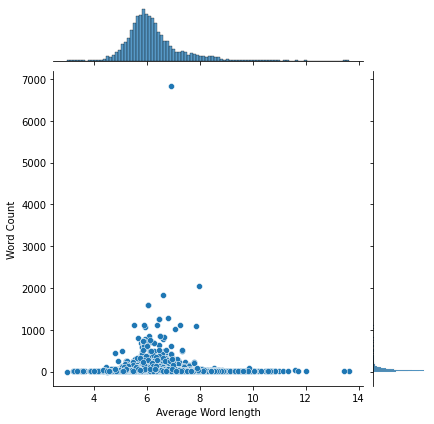

In [ ]:
sns.jointplot(x="Average Word length", y="Word Count", data=df_train)
plt.show();

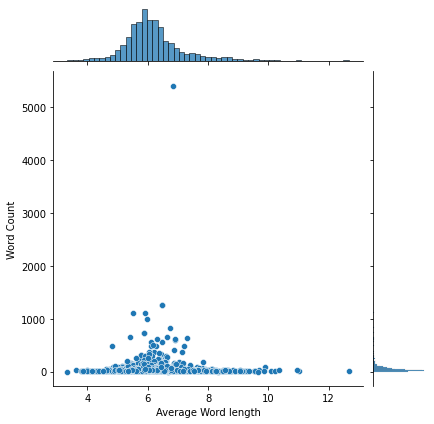

In [ ]:
sns.jointplot(x="Average Word length", y="Word Count", data=df_test)
plt.show();

**Observation:**
From the above plots it is cleare that word count and average word length have a relationship. The higher the wordcount the lower the average word length and vice versa.

In [ ]:
df_train.head()

,Word Count,Average Word length,Topic 1,Topic 2,tfidf_d0,tfidf_d1,tfidf_d2,tfidf_d3,tfidf_d4,tfidf_d5,...,tfidf_w2v_d292,tfidf_w2v_d293,tfidf_w2v_d294,tfidf_w2v_d295,tfidf_w2v_d296,tfidf_w2v_d297,tfidf_w2v_d298,tfidf_w2v_d299,index,target
0,11.0,11.000000,0.047059,0.952941,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.289670,0.397418,0.127676,-0.483602,-0.030861,-0.122744,-0.072975,-0.218627,761,1
1,51.0,6.000000,0.989303,0.010697,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.353407,0.116068,0.016189,-0.275174,-0.141859,0.334654,0.074983,-0.068327,3548,0
2,8.0,6.750000,0.057939,0.942061,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,801,1
3,51.0,5.392157,0.012336,0.987664,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.130110,0.011601,0.030129,-0.100159,-0.087964,0.206661,-0.132469,-0.154478,3150,0
4,126.0,6.555556,0.901002,0.098998,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.135693,0.015914,0.001565,-0.184725,-0.040489,0.069787,-0.027075,-0.100662,5655,1


**Multivarient Analysis**

**TSNE for word embeddings**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


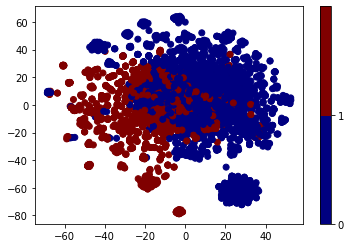

In [ ]:
from sklearn.manifold import TSNE
plt.close()
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(df_train[["tfidf_d"+str(i) for i in range(0,3016)]])
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=df_train["target"], cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.clim(0, 2)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


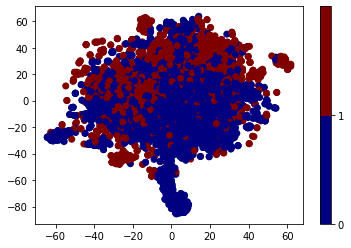

In [ ]:
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(df_train[["avg_wv_d"+str(i) for i in range(0,300)]])
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=df_train["target"], cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.clim(0, 2)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


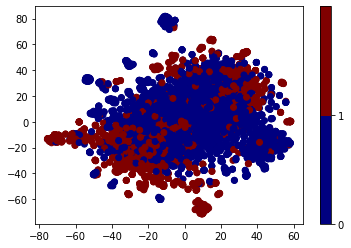

In [ ]:
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(df_train[["tfidf_w2v_d"+str(i) for i in range(0,300)]])
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=df_train["target"], cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.clim(0, 2)
plt.show()

**Observation:**
From the above plots of TSNE with various perplexity values, TF-IDF features can be seperated easily than avg W2V or TF-IDF weighted W2V.

In [ ]:
df = df_train[["Word Count","Average Word length","Topic 1","Topic 2","target"]]

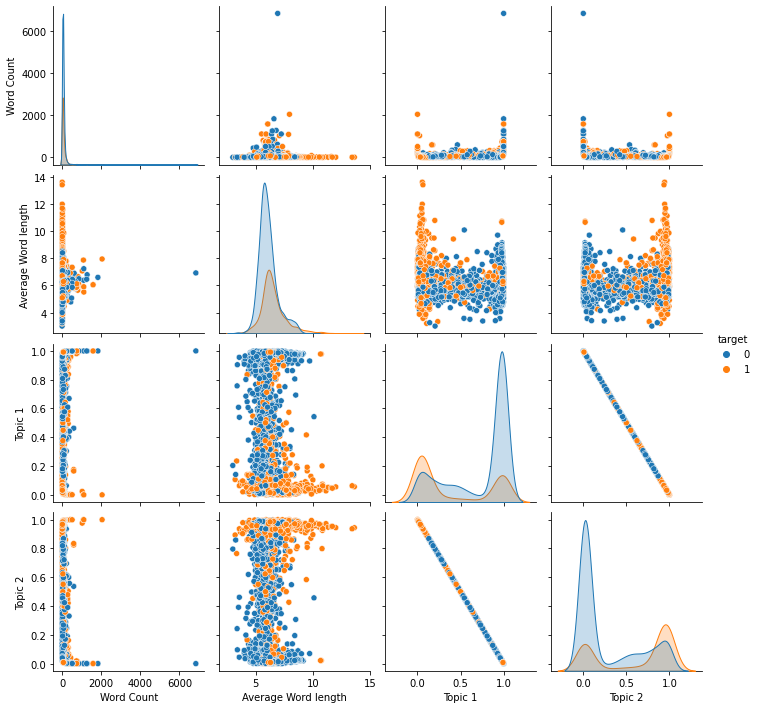

In [ ]:
sns.pairplot(df,hue="target")

**Observation:**

From the above pairplots it is clear that email belonging to class "1" belongs to "Topic 2" mostly and emails belonging to class "0" belongs to "Topic 1" mostly as we can see high density of these points in average word length vs topic 1,topic 2.

The probability of class "0" emails belomging to "Topic 1" is high and "Topic 2" is low and vice versa.

So Topic 1 and Topic 2 will be usefull in classifying spam emails.



In [ ]:
cols = ["Word Count","Average Word length","Topic 1","Topic 2"]

In [ ]:
cols.extend(["tfidf_d"+str(i) for i in range(0,3286)])

In [ ]:
cols.extend(["target"])

In [ ]:
preprocessed_train = df_train[cols]
preprocessed_test = df_test[cols]

In [ ]:
preprocessed_train.to_csv("preprocessed_train.csv")
!cp preprocessed_train.csv "drive/My Drive/"
preprocessed_test.to_csv("preprocessed_test.csv")
!cp preprocessed_test.csv "drive/My Drive/"

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/preprocessed_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/preprocessed_test.csv")

In [ ]:
y_train = df_train['target']
y_test = df_test['target']
X_train = df_train.drop(['target'],axis=1)
X_test = df_test.drop(['target'],axis=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from sklearn.metrics import classification_report

# **Random Forest**



In [ ]:
def evaluate(y_test,y_pred):
  '''This function is used to evaluate a model on metrics like accuracy,f1 score,f-0.5 score and confusion matrix '''
  print("ACCURACY:", accuracy_score(y_test, y_pred))
  print("F-1 SCORE:", f1_score(y_test, y_pred))
  print("F-0.5 SCORE WEIGHTED:", fbeta_score(y_test, y_pred, average='weighted', beta=0.5))
  print("F-0.5 SCORE MACRO:", fbeta_score(y_test, y_pred, average='macro', beta=0.5))
  print("F-0.5 SCORE MICRO:", fbeta_score(y_test, y_pred, average='micro', beta=0.5))
  print(classification_report(y_test, y_pred, target_names=['0','1']))
  print("CONFUSION MATRIX:")
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [ ]:
params = {'n_estimators': [100, 200, 500, 1000, 1500, 2000]}

In [ ]:
clf = RandomForestClassifier(random_state = 42) 


In [ ]:
rf_clf = GridSearchCV(clf,param_grid=params,verbose=10,n_jobs=-1)
rf_clf.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 500, 1000, 1500, 2000]},
             verbose=10)

In [ ]:
rf_clf.best_params_

{'n_estimators': 2000}

ACCURACY: 0.9818965517241379
F-1 SCORE: 0.97196261682243
F-0.5 SCORE WEIGHTED: 0.9818702841226884
F-0.5 SCORE MACRO: 0.981136980248881
F-0.5 SCORE MICRO: 0.9818965517241379
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       781
           1       0.98      0.96      0.97       379

    accuracy                           0.98      1160
   macro avg       0.98      0.98      0.98      1160
weighted avg       0.98      0.98      0.98      1160

CONFUSION MATRIX:


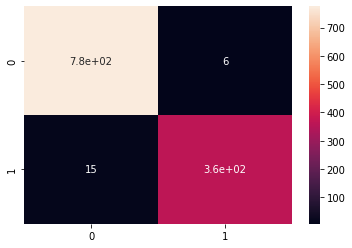

In [ ]:
clf = RandomForestClassifier(random_state = 42,n_estimators=2000,n_jobs=-1) 
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

# **XGBoost**

In [ ]:
xgbclf = xgb.XGBClassifier()
#xgbclf.fit(X_train, y_train)
#y_pred = xgbclf.predict(X_test)
#evaluate(y_test,y_pred)

In [ ]:
prams={
'n_estimators':[100,200,500,1000,2000],
'max_depth':[3,5,10]
}
random_cfl1=RandomizedSearchCV(xgbclf,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

In [ ]:
random_cfl1.best_params_

In [ ]:
xclf = xgb.XGBClassifier(n_estimators=500,max_depth=3)
xclf.fit(X_train, y_train)
y_pred = xclf.predict(X_test)
evaluate(y_test,y_pred)

# **Naive Bayes**

ACCURACY: 0.8051724137931034
F-1 SCORE: 0.769857433808554
F-0.5 SCORE WEIGHTED: 0.8432861439485478
F-0.5 SCORE MACRO: 0.8005358104594613
F-0.5 SCORE MICRO: 0.8051724137931034
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       781
           1       0.63      1.00      0.77       379

    accuracy                           0.81      1160
   macro avg       0.81      0.85      0.80      1160
weighted avg       0.88      0.81      0.81      1160

CONFUSION MATRIX:


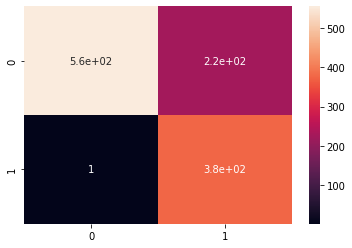

In [ ]:
clf = GaussianNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

In [ ]:
params = {'alpha':[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}

In [ ]:
clf = MultinomialNB()

In [ ]:
nb_clf = GridSearchCV(clf,param_grid=params,verbose=10,n_jobs=-1)
nb_clf.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100,
                                   1000]},
             verbose=10)

In [ ]:
nb_clf.best_params_

{'alpha': 1e-05}

ACCURACY: 0.8991379310344828
F-1 SCORE: 0.8608799048751488
F-0.5 SCORE WEIGHTED: 0.9071647812713826
F-0.5 SCORE MACRO: 0.8828666352229356
F-0.5 SCORE MICRO: 0.8991379310344828
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       781
           1       0.78      0.96      0.86       379

    accuracy                           0.90      1160
   macro avg       0.88      0.91      0.89      1160
weighted avg       0.91      0.90      0.90      1160

CONFUSION MATRIX:


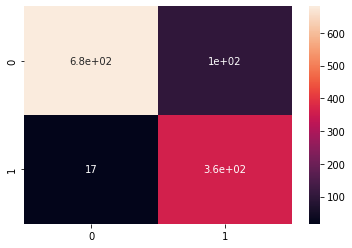

In [ ]:
clf = MultinomialNB(alpha=1e-05)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

# **SVM**

In [ ]:
params= {'alpha':[10 ** x for x in range(-5, 3)]}

In [ ]:
clf = SGDClassifier(penalty='l2', loss='hinge', random_state=42)
svm_clf = GridSearchCV(clf,param_grid=params,verbose=10,n_jobs=-1)
svm_clf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                                   100]},
             verbose=10)

In [ ]:
svm_clf.best_params_

{'alpha': 1e-05}

ACCURACY: 0.6103448275862069
F-1 SCORE: 0.5349794238683128
F-0.5 SCORE WEIGHTED: 0.6490288946829917
F-0.5 SCORE MACRO: 0.6036112691780049
F-0.5 SCORE MICRO: 0.6103448275862069
              precision    recall  f1-score   support

           0       0.79      0.57      0.66       781
           1       0.44      0.69      0.53       379

    accuracy                           0.61      1160
   macro avg       0.61      0.63      0.60      1160
weighted avg       0.68      0.61      0.62      1160

CONFUSION MATRIX:


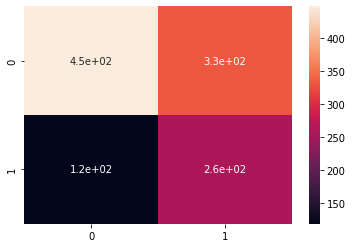

In [ ]:
clf = SGDClassifier(alpha=1e-05,penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

# **Logistic Regression**

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


ACCURACY: 0.9353448275862069
F-1 SCORE: 0.8956884561891516
F-0.5 SCORE WEIGHTED: 0.9349789174615968
F-0.5 SCORE MACRO: 0.9326216118511277
F-0.5 SCORE MICRO: 0.9353448275862067
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       781
           1       0.95      0.85      0.90       379

    accuracy                           0.94      1160
   macro avg       0.94      0.91      0.92      1160
weighted avg       0.94      0.94      0.93      1160

CONFUSION MATRIX:


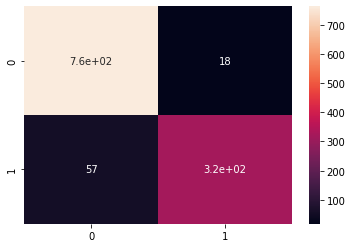

In [ ]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
evaluate(y_test,y_pred)

# **Decision Tree**

In [ ]:
clf = DecisionTreeClassifier(random_state=0)

In [ ]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100]
}

In [ ]:
dt = GridSearchCV(estimator=clf, param_grid=params, n_jobs=-1, verbose=1)

In [ ]:
dt.fit(X_train,y_train)
dt.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'max_depth': 20, 'min_samples_leaf': 5}

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=20,min_samples_leaf=5,random_state=0)
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, random_state=0)

ACCURACY: 0.9327586206896552
F-1 SCORE: 0.8970976253298153
F-0.5 SCORE WEIGHTED: 0.9327586206896552
F-0.5 SCORE MACRO: 0.9235808229081854
F-0.5 SCORE MICRO: 0.9327586206896552
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       781
           1       0.90      0.90      0.90       379

    accuracy                           0.93      1160
   macro avg       0.92      0.92      0.92      1160
weighted avg       0.93      0.93      0.93      1160

CONFUSION MATRIX:


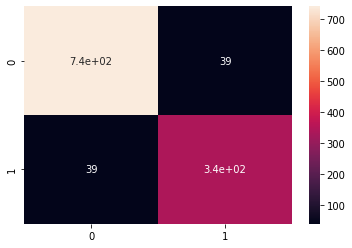

In [ ]:
y_pred = dt_clf.predict(X_test)
evaluate(y_test,y_pred)

# **Conclusion:**
In conclusion on seeing various model performance on the given dataset the Gradient boosted decision tree model performs well with email spamm classification dataset.

# **Results**

In [ ]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["MODEL","ACCURACY","F 0.5 SCORE"])
  
# Add rows
myTable.add_row(["Random Forest","0.98","0.98"])
myTable.add_row(["XGBoost", "0.97", "0.96"])
myTable.add_row(["Decision Tree","0.93","0.93"])
myTable.add_row(["Naive Bayes", "0.89","0.90"])
myTable.add_row(["Logistic Regression", "0.93", "0.93"])
myTable.add_row(["KNN", "0.67", "0.54"])
  
print(myTable)
 

+---------------------+----------+-------------+
|        MODEL        | ACCURACY | F 0.5 SCORE |
+---------------------+----------+-------------+
|    Random Forest    |   0.98   |     0.98    |
|       XGBoost       |   0.97   |     0.96    |
|    Decision Tree    |   0.93   |     0.93    |
|     Naive Bayes     |   0.89   |     0.90    |
| Logistic Regression |   0.93   |     0.93    |
|         KNN         |   0.67   |     0.54    |
+---------------------+----------+-------------+
